In [1]:
# Yiyang liu 
# 07/24
# Two VIT models: Dinov2 and ____


In [2]:

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
import os, sys
import cv2


In [3]:
import torch
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import requests
from transformers import Dinov2Config, Dinov2Model
from transformers import ViTModel, ViTFeatureExtractor

/home/yiyangl/.conda/envs/conda-env/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/yiyangl/.conda/envs/conda-env/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:

IMG_processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
Encoder_model = AutoModel.from_pretrained('facebook/dinov2-base')

In [6]:


class MemeImageSet():
    def __init__(self, img_dir, transform_method):
        self.img_dir = img_dir
        self.transform = transform_method
        self.images = []

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        #idx_lst = [i for i in range(len(os.listdir(self.img_dir)))]
        #Image_set = []
        
        #for i in idx_lst:
        image_batch = []
        item_list = os.listdir(self.img_dir)[idx]
        ct = 0
        for item in item_list:
            ct += 1
            img_path = os.path.join(self.img_dir,item)
            image = cv2.imread(img_path)
            image = cv2.resize(image,(224, 224))
            image_batch.append(image)
        image_batch = np.vstack(image_batch).reshape(ct,224,224,3)
        print(image_batch.shape)
        if self.transform:
            image = self.transform(images = image_batch, return_tensors = 'pt')
            
        return image
    
    def getimages(self,idx):
        
        for i in idx:
            item = os.listdir(self.img_dir)[i]
            img_path = os.path.join(self.img_dir,item)
            image = cv2.imread(img_path)
            #image = cv2.resize(image,(224, 224,3))
            self.images.append(image)
            
        return self.images
            
        

In [7]:
p = 'Images/'

IMG_set = MemeImageSet(p,IMG_processor)
img_batchfeatures = IMG_set[0:50]




(50, 224, 224, 3)


In [8]:
print(type(img_batchfeatures))
print(img_batchfeatures['pixel_values'].shape)

<class 'transformers.image_processing_base.BatchFeature'>
torch.Size([50, 3, 224, 224])


In [9]:

idx_lst = [i for i in range(10000)] #change to other number if needed
idx  = idx_lst[0:50]
img_getimages = IMG_set.getimages(idx)

In [10]:
#input_vec  =
output = Encoder_model(**img_batchfeatures, output_attentions = 1)

In [11]:
print(output.keys())

odict_keys(['last_hidden_state', 'pooler_output', 'attentions'])


In [12]:
out1 = output['last_hidden_state']
out2 =  output['pooler_output']
out_attention =  output['attentions']

In [13]:
print(out1.shape)
print(out2.shape)
#print((out_attention[10].shape))#tuple of n, for n attention layers

torch.Size([50, 257, 768])
torch.Size([50, 768])


In [114]:
imgid =28
layer = 7



In [115]:
#control which image to show
layers_att = []
for l in range(12):
    layers_att.append(out_attention[layer].detach())
    


In [116]:
last_layer_attention = layers_att[layer]
#last_layer_attention = last_layer_attention[:,:,0:256,0:256]
print(last_layer_attention.shape) #the last token is cls
num_patches = int(np.sqrt(last_layer_attention.shape[-1]-1))
print('number of patches:' + str(num_patches))


torch.Size([50, 12, 257, 257])
number of patches:16


/home/yiyangl/.conda/envs/conda-env/lib/python3.9/site-packages/torch/_tensor.py:893: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


(224, 224)


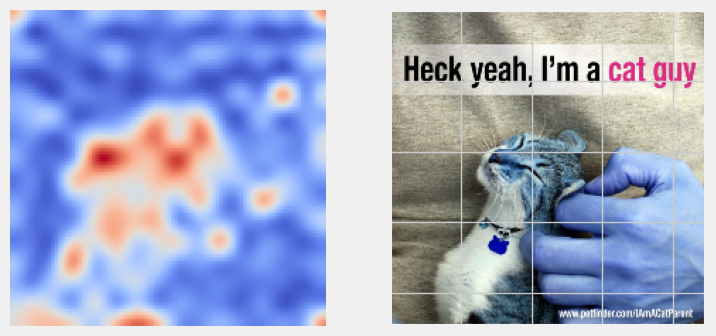

In [117]:
# Plot the attention map of a certain layer

from scipy.ndimage import zoom
# Sample data
att_ = last_layer_attention[imgid,:,0,1:257].squeeze(0)

att = att_.mean(axis = 0).resize(num_patches,num_patches)
att = zoom(att, 224/num_patches)
print(att.shape)
#residual_att = torch.eye(att.size(1))
#aug_att = att + residual_att
#aug_att = aug_att / aug_att.sum(dim=-1).unsqueeze(-1)

# Create a figure with a 2x1 grid of Axes, sharing x and y axes
fig, ax = plt.subplots(1,2, figsize=(8, 8))

# Flatten the axes array
#axes = axes.flatten()

#for head in range(12):
# Plot different plots on each Axes
#    data = att[head].squeeze(0)
#   data = np.resize(data, (num_patches,num_patches))
#    sns.heatmap(data,  cmap='coolwarm',ax = axes[head], cbar = 0)
#    axes[head].set_title('Attention Head # '+ str(head+1),fontsize = 8)
#    axes[head].xaxis.set_ticks_position('none')
#    axes[head].yaxis.set_ticks_position('none')
#    axes[head].set_xticklabels([])
#    axes[head].set_yticklabels([])
#    axes[head].set_aspect('equal')

p = img_getimages[imgid]

# Adjust 

sns.heatmap(att,  cmap='coolwarm', cbar = 0, ax = ax[0])
ax[1].imshow(cv2.resize(p,(224,224)))
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[0].xaxis.set_ticks_position('none')
ax[1].xaxis.set_ticks_position('none')
ax[0].yaxis.set_ticks_position('none')
ax[1].yaxis.set_ticks_position('none')
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
plt.show()

In [118]:
# attention rollout
att_1 = layers_att[0][imgid,:,:,:]
att_mean = att_1.mean(axis = 0)
residual_att = torch.eye(att_mean.size(1))
aug_att = att_mean + residual_att
aug_att = aug_att / aug_att.sum(dim=-1).unsqueeze(-1)

rollout = np.zeros((12,aug_att.shape[0],aug_att.shape[1]))
rollout[0] = att_mean
for l in range(1,12):
    
    rollout[l] = np.matmul(aug_att,rollout[l-1])
    att_1 = layers_att[l][imgid,:,:,:].squeeze(0)
    att_mean = att_1.mean(axis = 0)
    residual_att = torch.eye(att_mean.size(1))
    aug_att = att_mean + residual_att
    aug_att = aug_att / aug_att.sum(dim=-1).unsqueeze(-1)
    
    
    

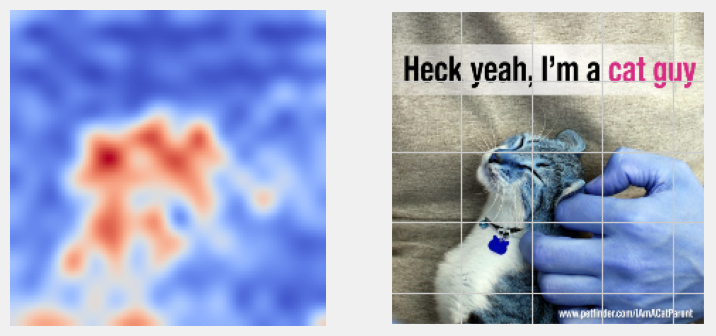

In [119]:
# Create a figure with a 2x1 grid of Axes, sharing x and y axes

att_r = rollout[-1,0,1:257]
#print(att_r)
att = np.resize(att_r,(num_patches,num_patches))
#print(att)
att = zoom(att, 224/num_patches)


fig, ax = plt.subplots(1,2, figsize=(8, 8))

p = img_getimages[imgid]



sns.heatmap(att,  cmap='coolwarm', cbar = 0, ax = ax[0])
ax[1].imshow(cv2.resize(p,(224,224)))
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[0].xaxis.set_ticks_position('none')
ax[1].xaxis.set_ticks_position('none')
ax[0].yaxis.set_ticks_position('none')
ax[1].yaxis.set_ticks_position('none')
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
plt.show()